#### load in modules

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

#### read in IATA global air traffic data

In [2]:
# load in within-Italy commute data, ignore first line and use second line as header
italy_commute_full = pd.read_csv('./od_matrix_daily_flows_norm_full_2020_01_18_2020_06_26.csv')

In [23]:
# compute average from March to (end of) May
italy_commute_MarMay_avg = italy_commute_full[['p1', 'p2']].copy()
italy_commute_MarMay_avg['flow'] = italy_commute_full.drop(columns=['p1', 'p2']).iloc[:,43:135].mean(axis=1).values

#### symmetrise commute data and average

In [24]:
# remove self loops
italy_commute_MarMay_avg = italy_commute_MarMay_avg[italy_commute_MarMay_avg.p1 != italy_commute_MarMay_avg.p2].copy()
# label each row with a unique "a-b" string, where a and b are origin_id and destination_id sorted in ascending order
italy_commute_MarMay_avg['od'] = italy_commute_MarMay_avg[['p1', 'p2']].apply(lambda x: '-'.join([str(y) for y in sorted(x)]), axis=1)

In [25]:
# calculate average of both directions, in cases where there is a single direction, take that as the average
italy_commute_MarMay_avg = italy_commute_MarMay_avg.groupby('od').mean().reset_index().drop(columns=['p1', 'p2'])
# extract p1 and p2 from od
italy_commute_MarMay_avg['p1'] = italy_commute_MarMay_avg['od'].apply(lambda x: x.split('-')[0])
italy_commute_MarMay_avg['p2'] = italy_commute_MarMay_avg['od'].apply(lambda x: x.split('-')[1])

#### perform graph-thinning

In [26]:
# first edges in ascending order
italy_commute_MarMay_avg_thinned = italy_commute_MarMay_avg.sort_values('flow', ascending=True).reset_index(drop=True).copy()
# remove edges with 0 flow
italy_commute_MarMay_avg_thinned = italy_commute_MarMay_avg_thinned[italy_commute_MarMay_avg_thinned.flow != 0]

In [41]:
# iterate over edges and retain only x of edges with highest flow, while ensuring that the graph remains connected
thinning_threshold = 0.15
# construct graph to be thinned
italy_commute_MarMay_avg_thinned_graph = nx.from_pandas_edgelist(italy_commute_MarMay_avg_thinned, source='p1', target='p2',
                                                                 edge_attr='flow', create_using=nx.Graph)

# print number of nodes and edges in the graph before thinning
print('Number of nodes before graph-thinning:', len(italy_commute_MarMay_avg_thinned_graph.nodes))
print('Number of edges before graph-thinning:', len(italy_commute_MarMay_avg_thinned_graph.edges))

# thin graph (iterate over entries in italy_commute_MarMay_avg_sym_thinned)
edges_to_remove = len(italy_commute_MarMay_avg_thinned) * (1 - thinning_threshold)
edges_removed = 0
for edge in italy_commute_MarMay_avg_thinned.iterrows():
    if edges_removed >= edges_to_remove:
        break
    # check that the graph would main connected if the edge was removed
    italy_commute_MarMay_avg_thinned_graph.remove_edge(edge[1].p1, edge[1].p2)
    if not nx.is_connected(italy_commute_MarMay_avg_thinned_graph):
        # add the edge back
        italy_commute_MarMay_avg_thinned_graph.add_edge(edge[1].p2, edge[1].p1)
        continue
    edges_removed += 1

# print number of nodes and edges in the graph after thinning
print('Number of nodes after graph-thinning:', len(italy_commute_MarMay_avg_thinned_graph.nodes))
print('Number of edges after graph-thinning:', len(italy_commute_MarMay_avg_thinned_graph.edges))
# check that the graph is connected
print('Is the graph connected?', nx.is_connected(italy_commute_MarMay_avg_thinned_graph))

Number of nodes before graph-thinning: 107
Number of edges before graph-thinning: 1976
Number of nodes after graph-thinning: 107
Number of edges after graph-thinning: 296
Is the graph connected? True


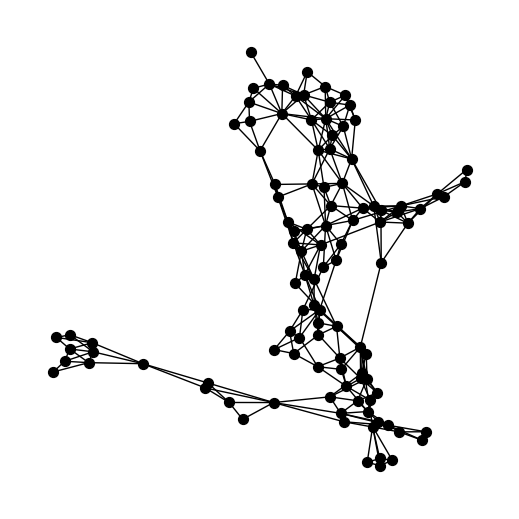

In [43]:
# draw the thinned graph
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(italy_commute_MarMay_avg_thinned_graph)
nx.draw(italy_commute_MarMay_avg_thinned_graph, pos, node_size=50, node_color='k', with_labels=False)
plt.show()

#### plot thinned graph on a map

In [30]:
# load Italy shape file
italy_shp = gpd.read_file('./Municipal_Boundaries_of_Italy_2019')

In [36]:
# dissolve to get outer and inner boundaries
italy_inner_boundary_shp = italy_shp.dissolve(by='COD_PROV').reset_index()
italy_outer_boundary_shp = italy_shp.dissolve().reset_index()

In [37]:
# extract province centroids
province_centroids = {}
for province in italy_inner_boundary_shp.COD_PROV.unique():
    centroid = italy_inner_boundary_shp[italy_inner_boundary_shp.COD_PROV == province].geometry.centroid
    province_centroids[str(province)] = (centroid.x.values[0], centroid.y.values[0])

/var/folders/q9/0h40wkyj4s79vh8zt8z0yssm0000gp/T/ipykernel_62983/3298187205.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = italy_inner_boundary_shp[italy_inner_boundary_shp.COD_PROV == province].geometry.centroid
/var/folders/q9/0h40wkyj4s79vh8zt8z0yssm0000gp/T/ipykernel_62983/3298187205.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = italy_inner_boundary_shp[italy_inner_boundary_shp.COD_PROV == province].geometry.centroid
/var/folders/q9/0h40wkyj4s79vh8zt8z0yssm0000gp/T/ipykernel_62983/3298187205.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this opera

In [44]:
# map country names to node ids
thinned_graph_id_centroids = { i: province_centroids[node] for i, node in enumerate(italy_commute_MarMay_avg_thinned_graph.nodes) }
# relabel nodes
thinned_graph_province_node_mapping = { node: i for i, node in enumerate(italy_commute_MarMay_avg_thinned_graph.nodes) }
thinned_graph_node_province_mapping = { i: node for i, node in enumerate(italy_commute_MarMay_avg_thinned_graph.nodes) }
italy_commute_MarMay_avg_thinned_graph = nx.relabel_nodes(italy_commute_MarMay_avg_thinned_graph, thinned_graph_province_node_mapping)

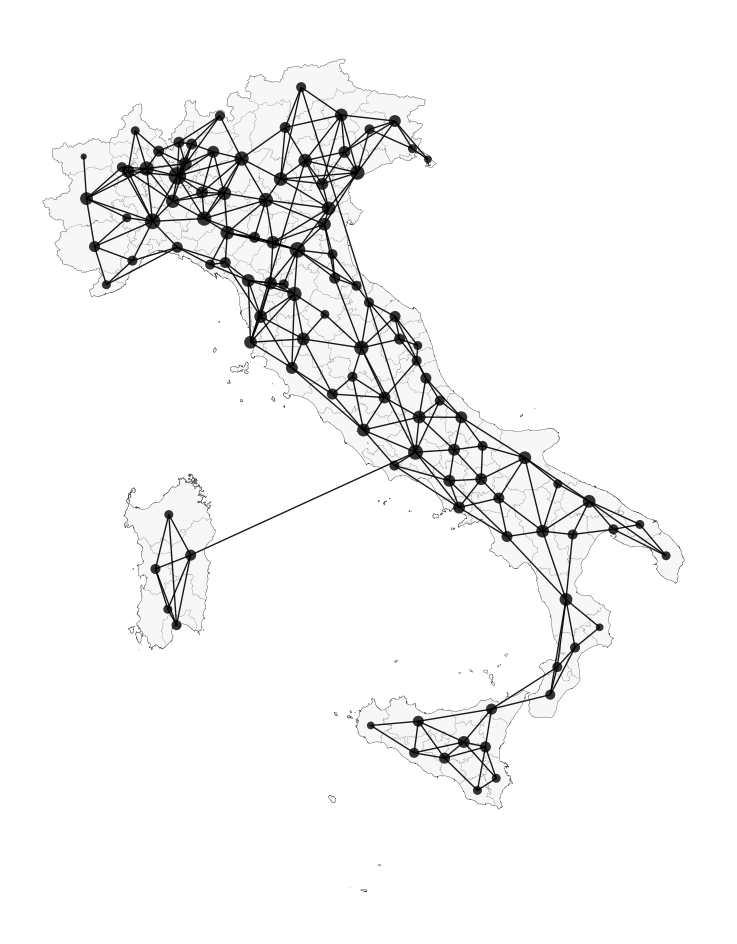

In [45]:
# draw network on map
fig, ax = plt.subplots(figsize=(12, 12))
italy_inner_boundary_shp.plot(ax=ax, color='#F7F7F7', edgecolor='#484848', linewidth=0.1, alpha=1)
italy_outer_boundary_shp.plot(ax=ax, color='none', edgecolor='#484848', linewidth=0.2, alpha=1)

# extract edges from graph
edges = italy_commute_MarMay_avg_thinned_graph.edges

# specify node radius according to degree
degree = dict(italy_commute_MarMay_avg_thinned_graph.degree)
max_degree = max(degree.values())
min_degree = min(degree.values())
# linear scale
node_sizes = [20 + (160 - 20) * (degree[node] - min_degree) / (max_degree - min_degree)
              for node in italy_commute_MarMay_avg_thinned_graph.nodes]

# draw graph
nx.draw_networkx_nodes(italy_commute_MarMay_avg_thinned_graph, thinned_graph_id_centroids,
                       node_size=node_sizes, linewidths=0, node_color='k', edgecolors='w', alpha=0.8, ax=ax)
nx.draw_networkx_edges(italy_commute_MarMay_avg_thinned_graph, thinned_graph_id_centroids,
                       width=1, alpha=0.9, edge_color='black', ax=ax)

# remove border
plt.gca().set_axis_off()

plt.show()

In [100]:
# export thinned graph as adjlist
nx.write_adjlist(italy_commute_MarMay_avg_thinned_graph, 'italy-thinning-threshold-0.15.adjlist')